## Honey Production Models and Analysis
### Author: Joseph Scavetta
#### Last Updated: 12/09/19

Honey bees, *Apis mellifera*, are widely used in the agricultural industry to pollinate many important crops, supply wax, 
and, known to most, produce honey. However, there has been concern that honey bee populations are at risk and are 
declining. With this risk, it becomes particularly important to understand all the factors that affect a colony’s 
ability to forage, pollinate, and produce honey. While honey production is not necessarily a direct indicator of colony 
health and strength, it is logical that a large colony that is able to sustain consistent foraging and in turn produce 
excessive amounts of honey may be stronger than one that cannot. One reason we might see a decline in honey bee 
strength is the presence of disease, notably, the *Varroa destructor* mite. However, another concern for honey bee health 
that does not seem to get much attention is changing climatic conditions. While we do see success with honey bees in 
varying climates, e.g., Florida and Canada, there is not much understanding of which, if any, climatic attributes are 
important to the strength of a colony. 

In this analysis, I will try to find any patterns in the production of honey and the climatic conditions around the 
colonies, further, I will explore patterns between honey production, disease presence, and agricultural land usage. 
Finally, I will create a prediction model of honey production based on climatic conditions, and explore the affect of 
future climatic conditions on overall honey production.

Import required packages.

In [1]:
import os

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.mask
import seaborn as sns
from IPython.display import IFrame
from folium import Choropleth
from rasterstats import zonal_stats
from scipy.cluster import hierarchy
from scipy.stats import expon, beta, randint
from shapely.geometry import mapping, box
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tqdm import tqdm

First, we need to clean and organize our data. We have multiple files containing data from the annual census conducted 
by the United Stated Department of Agriculture (USDA), provided by the National Agricultural Statistics Service (NASS) 
https://quickstats.nass.usda.gov/. We are using 2017’s census, which includes county level data for honey production, 
number of colonies, and agricultural land usage. We are also using data from a 2017 survey which holds state level data 
on the percent of colonies affected by disease, varroa mites, pesticides, or some unknown cause.

**Note:** Something seems off in the honey production data. Some counties have ridiculous pounds of honey per colony 
values. I have cut out all samples exceeding 175 pounds of honey per colony as they do not seem realistic.

In [2]:
def read_usda_data(filename, has_county=True):
    if has_county:
        columns = ['State ANSI', 'Ag District Code', 'County ANSI', 'Data Item', 'Value']
    else:
        columns = ['State ANSI', 'Data Item', 'Value']

    df = pd.read_csv(filename)[columns]
    df = df[df.Value != ' (D)']
    df = df[df['State ANSI'].notnull()]
    df['State ANSI'] = df['State ANSI'].astype('int').astype('str')

    if has_county:
        df['County ANSI'].fillna(df['Ag District Code'], inplace=True)
        df.drop('Ag District Code', axis=1, inplace=True)
        df['County ANSI'] = df['County ANSI'].astype('int').astype('str')
        df = df.pivot_table(index=['State ANSI', 'County ANSI'], columns='Data Item',
                            values='Value', aggfunc='first').reset_index().rename_axis(None, axis=1)
    else:
        df = df.pivot_table(index='State ANSI', columns='Data Item',
                            values='Value', aggfunc='first').reset_index().rename_axis(None, axis=1)

    df[df == ' (Z)'] = 0
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(lambda x: x.str.replace(',', '').astype(float))
    df = df.dropna()

    return df


data = read_usda_data('Data/honey_production_county_2017.csv', True)
data = data.merge(read_usda_data('Data/colony_inventory_county_2017.csv', True), on=['State ANSI', 'County ANSI'])
data = data.merge(read_usda_data('Data/agricultural_land_county_2017.csv', True), on=['State ANSI', 'County ANSI'])
data = data.merge(read_usda_data('Data/colony_disease_state_2017.csv', False), on=['State ANSI'])

data.iloc[:, 2] = data.iloc[:, 2] / data.iloc[:, 3]
data = data.drop(data.columns[3], axis=1)
for i in range(3, 11):
    data.iloc[:, i] = data.iloc[:, i] / data.iloc[:, 11] * 100

data = data.drop(data.columns[11], axis=1)

data.columns = ['state', 'county', 'honey_per_colony', 'agricultural_other', 'cropland', 'cropland_harvested',
                'cropland_pastured', 'pastureland', 'woodland', 'woodland_pastured', 'agricultural_total',
                'affected_disease', 'affected_other', 'affected_pesticides', 'affected_pests', 'affected_unknown',
                'affected_varroa']

data = data[data.honey_per_colony <= 175]
data.head()

,state,county,honey_per_colony,agricultural_other,cropland,cropland_harvested,cropland_pastured,pastureland,woodland,woodland_pastured,agricultural_total,affected_disease,affected_other,affected_pesticides,affected_pests,affected_unknown,affected_varroa
0,1,1,53.5036,2.22633,2.31727,7.24332,0.135893,6.11255,10.4007,1.32791,29.7639,0.2,6.7,3.2,9.8,9.3,19.9
1,1,101,12,3.7389,1.81911,7.63659,1.87701,19.4658,9.48177,2.35318,46.3723,0.2,6.7,3.2,9.8,9.3,19.9
2,1,105,12.8571,3.77071,1.39586,6.88464,0.671116,7.48476,13.6301,1.60191,35.4391,0.2,6.7,3.2,9.8,9.3,19.9
3,1,107,56.1538,1.03986,1.27899,3.44504,0.0829618,4.02294,8.02992,0.684435,18.5842,0.2,6.7,3.2,9.8,9.3,19.9
4,1,109,33.915,3.3216,1.64604,6.59693,1.19407,7.59665,14.9827,3.18164,38.5196,0.2,6.7,3.2,9.8,9.3,19.9


We can now extract environmental data for our sample counties. We will use geographic raster data supplied by Worldclim,
specifically, bioclimatic variables (http://worldclim.org/bioclim). These variables are intended to be conditions that 
may be meaningful to biological species. Using a shapefile supplied by the U.S. Census Bureau's Master Address File / 
Topologically Integrated Geographic Encoding and Referencing (MAF/TIGER) Database (MTDB) 
https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile, 
we can calculate mean values for each environmental condition for each county.

In [3]:
counties = gpd.read_file('Data/us_county_shapefile/tl_2017_us_county.shp')
counties.COUNTYFP = counties.COUNTYFP.astype('int').astype('str')
counties.STATEFP = counties.STATEFP.astype('int').astype('str')

counties = counties[counties.STATEFP.isin([str(i) for i in range(1, 57) if i != 2])].to_crs(epsg=4326)
counties = counties[(counties.STATEFP != '51') | (counties.COUNTYFP != '678')] # Issue with this county.
extent = [mapping(box(*counties.total_bounds))]

bio_names = ['annual_mean_temp', 'annual_mean_diurnal_range', 'isothermality', 'temp_seasonality',
             'max_temp_warmest_month', 'min_temp_coldest_month', 'annual_temp_range', 'mean_temp_wettest_quarter',
             'mean_temp_driest_quarter', 'mean_temp_warmest_quarter', 'mean_temp_coldest_quarter', 'annual_precip',
             'precip_wettest_month', 'precip_driest_month', 'precip_seasonality', 'precip_wettest_quarter',
             'precip_driest_quarter', 'precip_warmest_quarter', 'precip_coldest_quarter']

county_climate_data = pd.DataFrame({'state': counties.STATEFP, 'county': counties.COUNTYFP})

bio_index = 0
for file in tqdm(os.listdir("Data/Bioclim")):
    raster = rasterio.open(f"Data/Bioclim/{file}")
    raster_crop, raster_crop_transform = rasterio.mask.mask(raster, extent, filled=False, crop=True)
    zone_stats = zonal_stats(counties, raster_crop[0], affine=raster_crop_transform, nodata=raster.nodata, stats='mean')

    counties[bio_names[bio_index]] = [stats['mean'] for stats in zone_stats]
    county_climate_data[bio_names[bio_index]] = [stats['mean'] for stats in zone_stats]

    for index, value in enumerate(zone_stats):
        state_fp = counties.iloc[index].STATEFP
        county_fp = counties.iloc[index].COUNTYFP
        data.loc[(data.state == state_fp) & (data.county == county_fp), bio_names[bio_index]] = value['mean']

    bio_index += 1

data.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [04:38<00:00, 14.65s/it]


,state,county,honey_per_colony,agricultural_other,cropland,cropland_harvested,cropland_pastured,pastureland,woodland,woodland_pastured,...,mean_temp_warmest_quarter,mean_temp_coldest_quarter,annual_precip,precip_wettest_month,precip_driest_month,precip_seasonality,precip_wettest_quarter,precip_driest_quarter,precip_warmest_quarter,precip_coldest_quarter
0,1,1,53.5036,2.22633,2.31727,7.24332,0.135893,6.11255,10.4007,1.32791,...,26.272444,8.521516,1396.000000,166.642857,71.988095,21.044067,434.202381,274.309524,328.345238,398.654762
1,1,101,12,3.7389,1.81911,7.63659,1.87701,19.4658,9.48177,2.35318,...,26.596718,9.265874,1381.267241,168.250000,66.905172,21.544102,430.353448,266.163793,336.482759,387.612069
2,1,105,12.8571,3.77071,1.39586,6.88464,0.671116,7.48476,13.6301,1.60191,...,26.229264,8.133950,1410.735849,161.179245,75.641509,20.282454,440.547170,272.216981,327.518868,410.047170
3,1,107,56.1538,1.03986,1.27899,3.44504,0.0829618,4.02294,8.02992,0.684435,...,26.000874,7.087960,1448.242424,162.689394,82.500000,20.497546,439.151515,269.795455,322.787879,415.136364
4,1,109,33.915,3.3216,1.64604,6.59693,1.19407,7.59665,14.9827,3.18164,...,26.243121,9.336603,1373.457447,165.542553,72.946809,20.706376,420.053191,267.457447,356.723404,372.851064


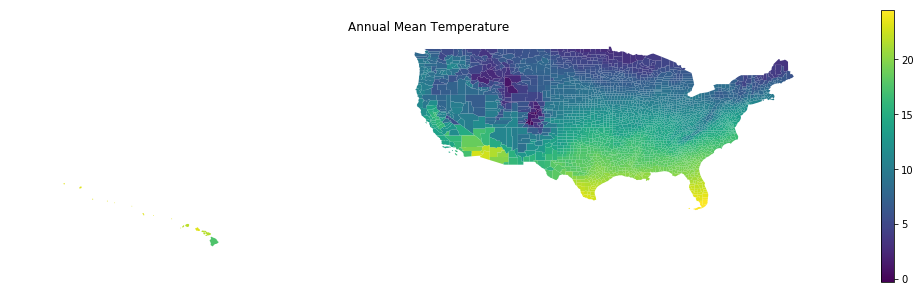

In [4]:
ax = counties.plot(column='annual_mean_temp', figsize=(18, 5), legend=True)
ax.axis('off')
ax.set_title('Annual Mean Temperature')
plt.show()

## Data Analysis

We will start by exploring models using all available data (climate, disease presence, and agricultural land usage).
Before we dive in, let's explore the data.

In [5]:
state_county = data[['state', 'county']].astype(str)
honey_prod = data.honey_per_colony.astype(float)
features = data.drop(['state', 'county', 'honey_per_colony'], axis=1).astype(float)

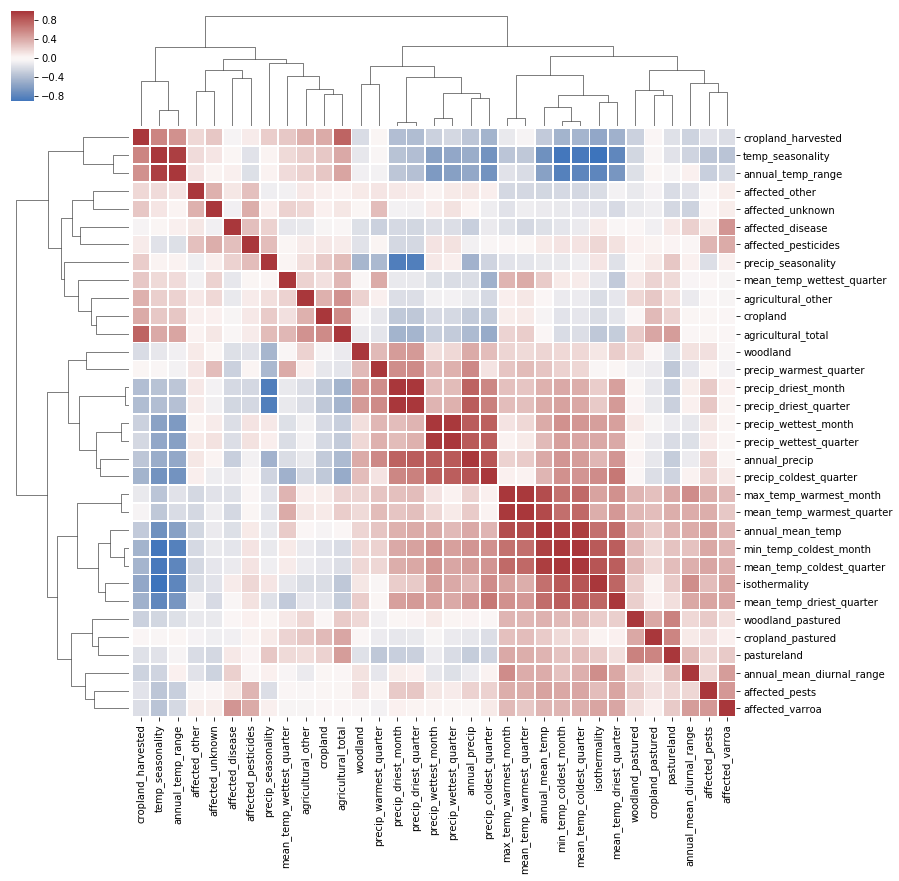

In [6]:
sns.clustermap(features.corr(), center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))

I don't notice any obious clusters between climate, disease presence, and agricultural land usage. There is some
strong correlation in our climate variables. However, we will retain them all for now.

## Models using All Variables

In [7]:
def train_baseline_models(x, y):
    regressors = [
        {'name': 'Linear Regression', 'model': LinearRegression},
        {'name': 'ElasticNet', 'model': ElasticNet},
        {'name': 'Random Forest', 'model': RandomForestRegressor},
        {'name': 'Gradient Boosting', 'model': GradientBoostingRegressor},
        {'name': 'AdaBoost', 'model': AdaBoostRegressor},
        {'name': 'SVM', 'model': SVR},
        {'name': 'K-NN', 'model': KNeighborsRegressor},
        {'name': 'Neural Network', 'model': MLPRegressor}
    ]
    
    results = pd.DataFrame(columns=['model', 'train', 'test'])
    for index, regressor in enumerate(regressors):
        pipe = Pipeline([
            ('scale', MinMaxScaler()),
            ('model', regressor['model']())
        ])

        scores = cross_validate(pipe, x, y, scoring='neg_root_mean_squared_error',
                                return_train_score=True, n_jobs=-1)
        
        results.loc[index] = [regressor['name'], scores['train_score'], scores['test_score']]
        
    plt.figure(figsize=(15,8))
    train_box = plt.boxplot(-results['train'], positions=np.array(range(1, results.shape[0]+1))*2.0-0.4, 
                            widths=0.6, patch_artist=True)
    test_box = plt.boxplot(-results['test'], positions=np.array(range(1, results.shape[0]+1))*2.0+0.4, 
                           widths=0.6, patch_artist=True)
    
    for bp, color in zip((train_box, test_box), ['pink', 'lightblue']):
        for patch in bp['boxes']:
            patch.set_facecolor(color)
    
    plt.plot([], c='pink', label='Training')
    plt.plot([], c='lightblue', label='Testing')
    plt.legend()
    
    plt.xticks(np.array(range(1, results.shape[0]+1))*2.0, results['model'])
    plt.xlim((0, (results.shape[0]+1)*2))
    plt.ylabel('Root Mean Squared Error')
    plt.tight_layout()
    plt.show()
    
pipe = Pipeline([
            ('scale', MinMaxScaler()),
            ('model', None)
        ])

param_distributions = [
    {
        'model': [GradientBoostingRegressor()],
        'model__n_estimators': randint(1, 2000), 
        'model__max_features': beta(2, 2),
    },
    {
        'model': [SVR()],
        'model__gamma': expon(scale=0.001), 
        'model__C': expon(scale=0.01)
    },
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': randint(1, 2000), 
        'model__max_features': beta(2, 2),
    }
]

Let's get a baseline score for a our regression models.

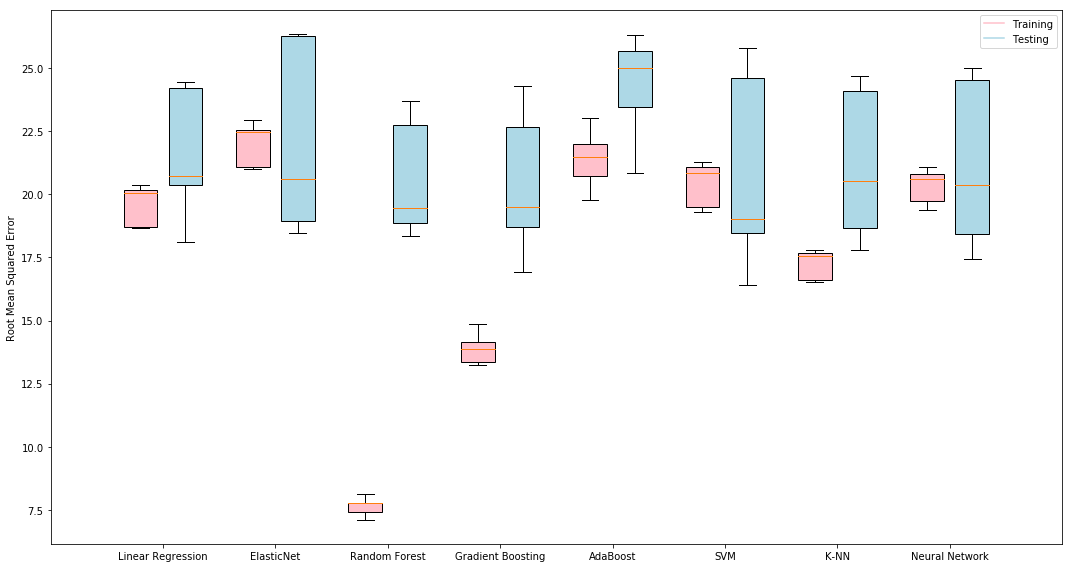

In [8]:
train_baseline_models(features, honey_prod)

I don't see any obvious winners. SVM looks like it achieved the best mean score, followed by Gradient Boost, then by 
Random Forest. 

In [9]:
search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, 
                            refit=True, cv=5, return_train_score=True)

search = search.fit(features, honey_prod)

print(f"{-search.cv_results_['mean_test_score'][search.best_index_]:0.2f} ± {search.cv_results_['std_test_score'][search.best_index_]:0.2f}")
print(search.best_params_['model'])

20.01 ± 2.65
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.0905498277453804,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=899,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


Doesn't look like we got much more performance. We can stop here and accept this as our best model.

## Models using Climate Variables


Now we can explore how well a model does with only climate data. This is desirable because we may be able to predict
future honey production using predicted future climate data.

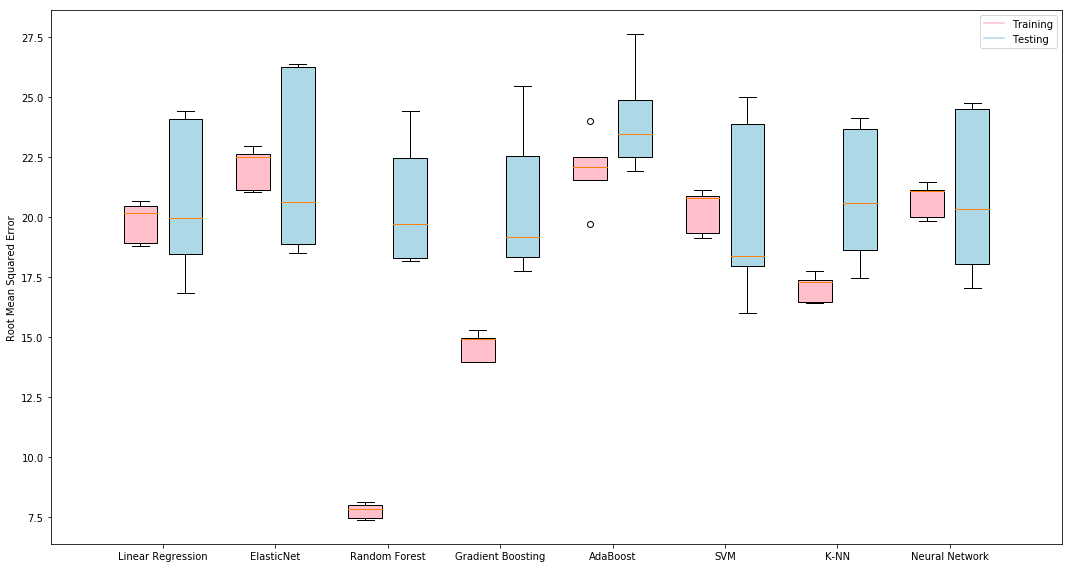

In [10]:
climate_features = features.iloc[:, 14:]
train_baseline_models(climate_features, honey_prod)

Looks like we still get similar performance when only using enviornmental features.

SVM looks like it achieved the best mean score again, followed by Gradient Boosting.

In [11]:
search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, 
                            refit=True, cv=5, return_train_score=True)

search = search.fit(climate_features, honey_prod)

print(f"{-search.cv_results_['mean_test_score'][search.best_index_]:0.2f} ± {search.cv_results_['std_test_score'][search.best_index_]:0.2f}")
print(search.best_params_['model'])

19.88 ± 2.82
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.09842034234977166,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1822,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


Before we explore the variables, let's see if we can get similar performance by removing some correlated features.

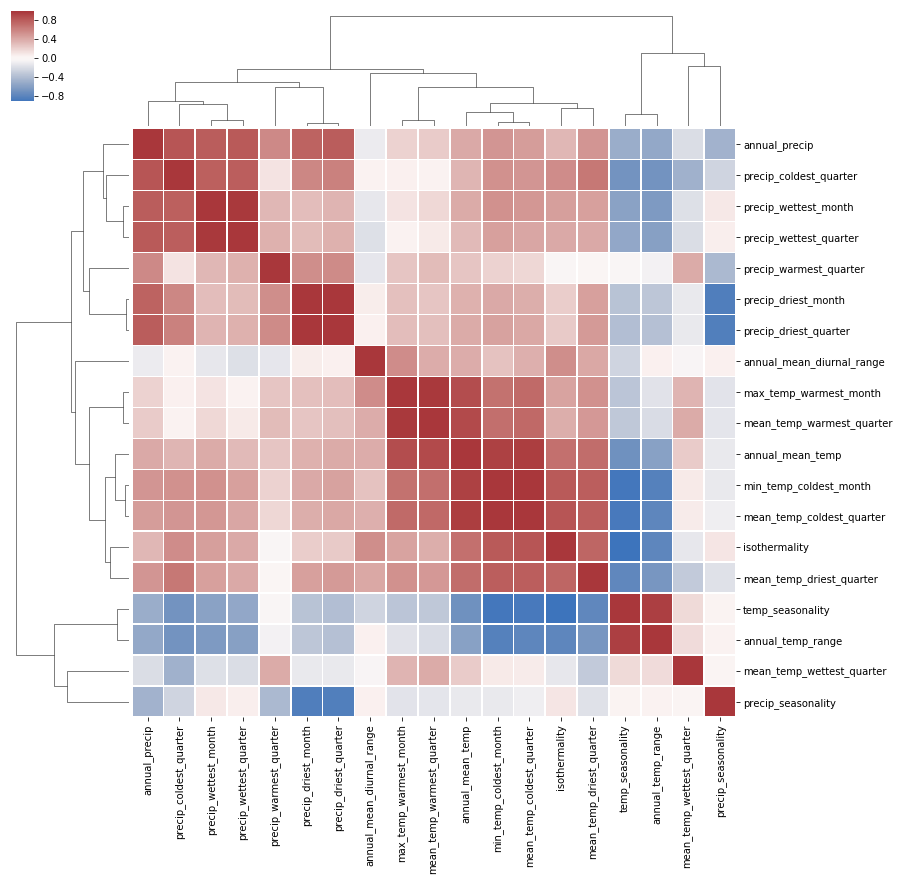

In [12]:
sns.clustermap(climate_features.corr(), center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))

Let's extract features from our correlated clusters.

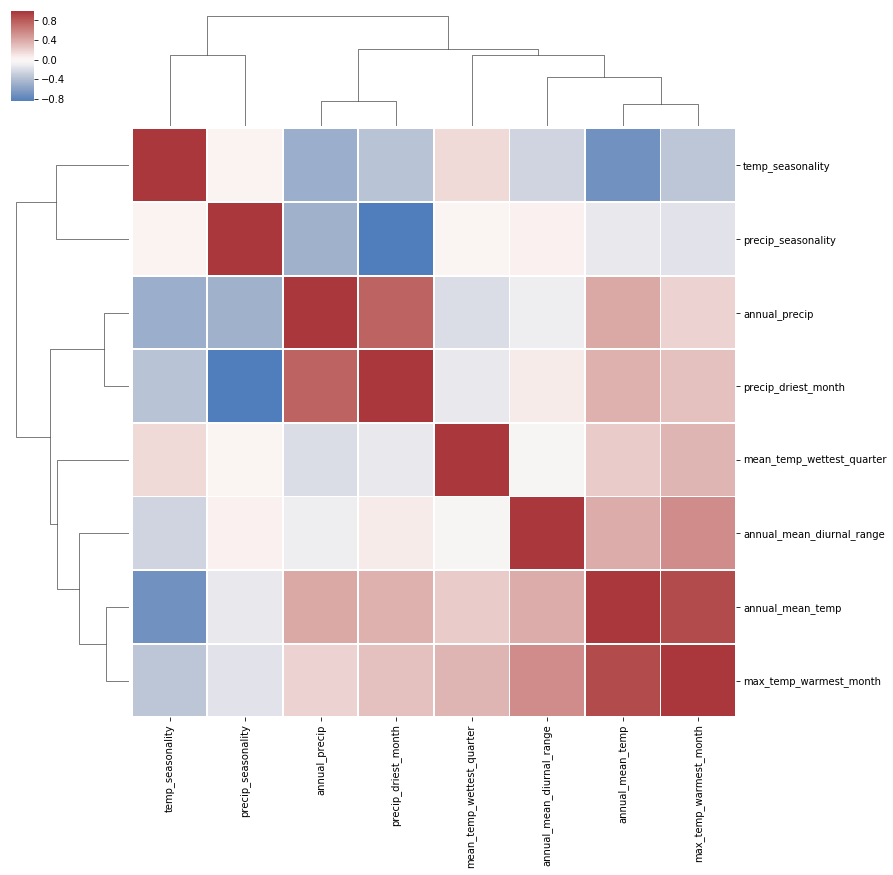

In [13]:
corr_linkage = hierarchy.ward(climate_features.corr())
cluster_ids = hierarchy.fcluster(corr_linkage, 8, criterion='maxclust')
cluster = {}
for index, cluster_id in enumerate(cluster_ids):
    if cluster_id not in cluster:
        cluster[cluster_id] = index

selected_features = [v for v in cluster.values()]

climate_features_subset = climate_features.iloc[:, selected_features]
sns.clustermap(climate_features_subset.corr(), center=0, cmap="vlag", linewidths=.75, figsize=(13, 13))

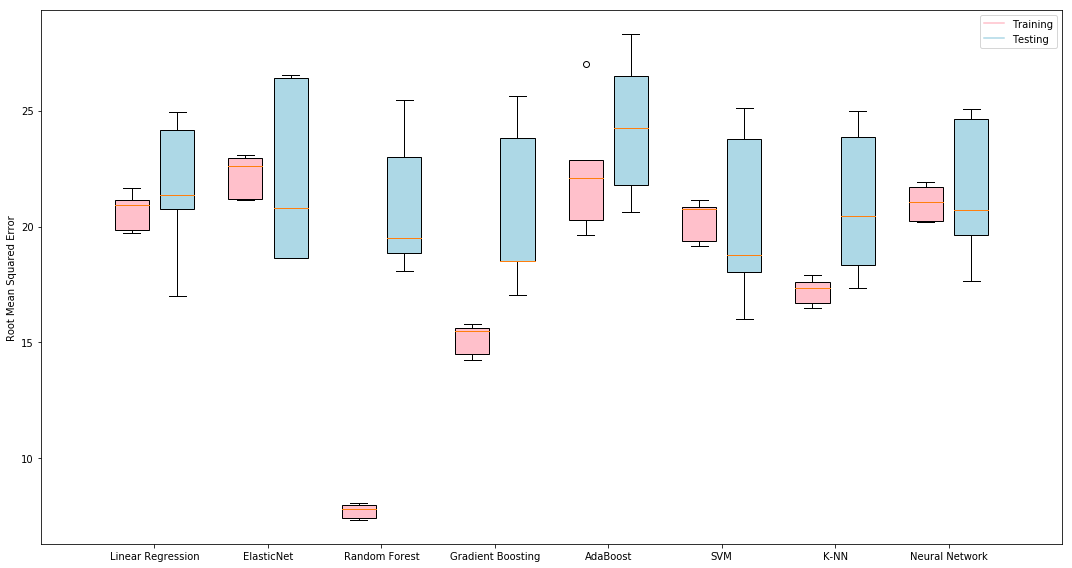

In [14]:
train_baseline_models(climate_features_subset, honey_prod)

In [15]:
search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, 
                            refit=True, cv=5, return_train_score=True)

search = search.fit(climate_features_subset, honey_prod)

print(f"{-search.cv_results_['mean_test_score'][search.best_index_]:0.2f} ± {search.cv_results_['std_test_score'][search.best_index_]:0.2f}")
print(search.best_params_['model'])

20.08 ± 2.90
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.14278961164621504,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1923,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


Looks like we can get similar performance by removing correlated features.

Now we can explore the most important features using permutation importance.

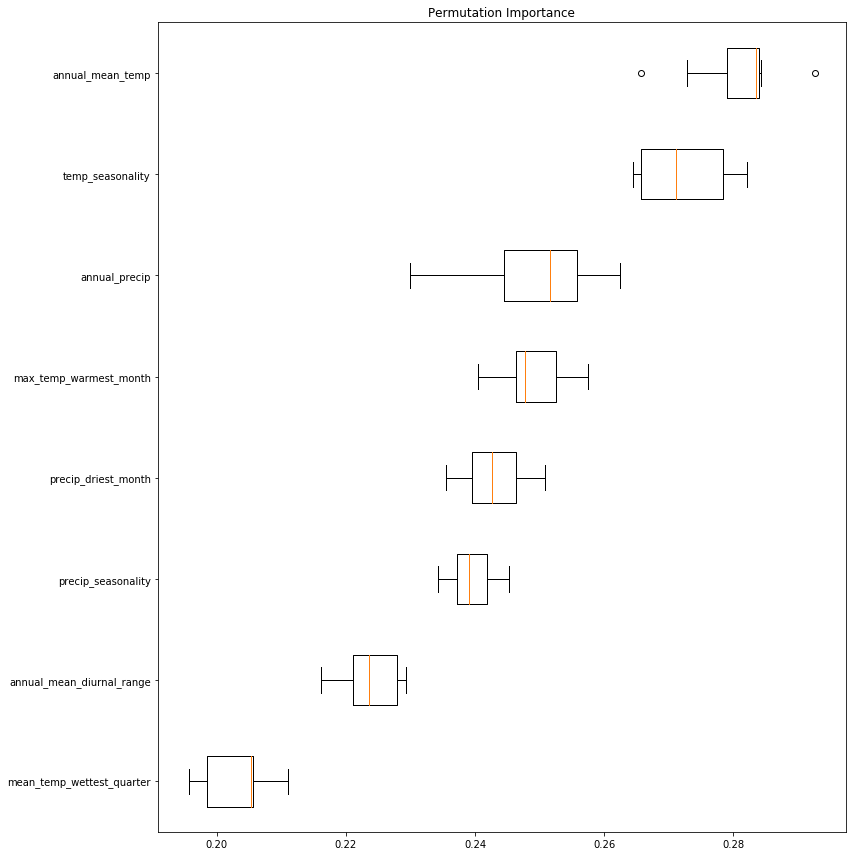

In [16]:
result = permutation_importance(search.best_estimator_, climate_features_subset, honey_prod, n_repeats=10, n_jobs=-1)
indices = result.importances_mean.argsort()
plt.figure(figsize=(12, 12))
plt.boxplot(result.importances[indices].T, vert=False, labels=climate_features_subset.columns[indices])
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()

We can explore how changes to the top three features alter honey production using partial dependence plots. We will explore
the top three features independently and as two-way interactions.

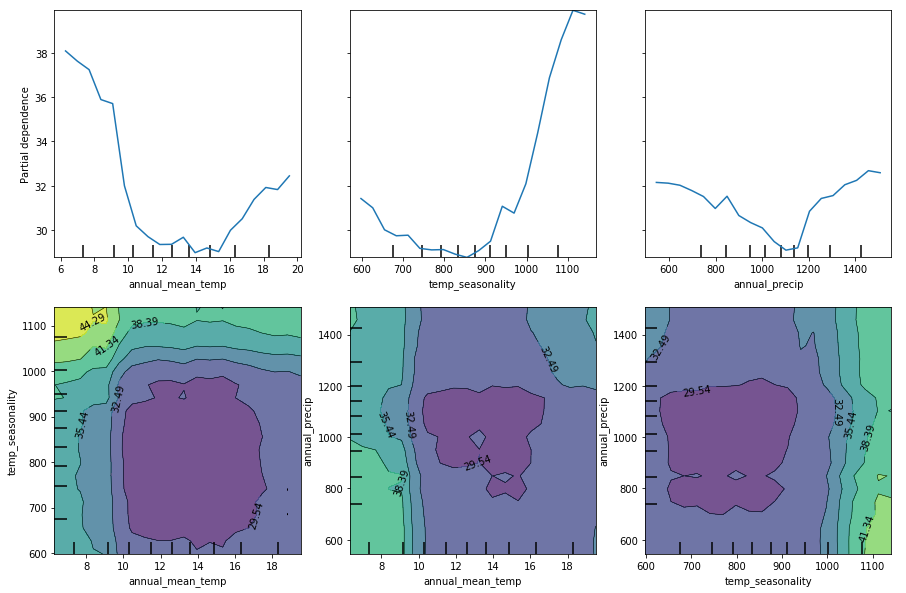

In [17]:
top_three = indices[::-1][:3]

partial_plots_indices = list(top_three)
partial_plots_indices.append(tuple(top_three[[0,1]]))
partial_plots_indices.append(tuple(top_three[[0,2]]))
partial_plots_indices.append(tuple(top_three[[1,2]]))
partial_plots_indices

fig, ax = plt.subplots(figsize=(15, 10))
tree_disp = plot_partial_dependence(search.best_estimator_, climate_features_subset, partial_plots_indices, 
                                    feature_names=climate_features_subset.columns,
                                    n_jobs=-1, grid_resolution=20, ax=ax)

## Predicting Honey Production per Colony with Projected Future Climate Data

We can now use projected climate data for the year 2050 given a Representative Concentration Pathway (RCP).
We are using RCP 4.5; emissions in RCP 4.5 peak around 2040, then decline.

First, we need to average the bioclim data for each county again and ensure the data is in the correct scale.

In [18]:
future_county_climate_data = pd.DataFrame({'state': counties.STATEFP, 'county': counties.COUNTYFP})

bio_index = 0
for file in tqdm(os.listdir("Data/Future CCSM4")):
    raster = rasterio.open(f"Data/Future CCSM4/{file}")
    raster_crop, raster_crop_transform = rasterio.mask.mask(raster, extent, filled=False, crop=True)
    zone_stats = zonal_stats(counties, raster_crop[0], affine=raster_crop_transform, nodata=raster.nodata, stats='mean')
    future_county_climate_data[bio_names[bio_index]] = [stats['mean'] for stats in zone_stats]    
    bio_index += 1
    
scale = ['annual_mean_temp', 'annual_mean_diurnal_range', 'temp_seasonality', 'max_temp_warmest_month', 
         'min_temp_coldest_month', 'annual_temp_range', 'mean_temp_wettest_quarter', 'mean_temp_driest_quarter', 
         'mean_temp_warmest_quarter', 'mean_temp_coldest_quarter']

future_county_climate_data[scale] = future_county_climate_data[scale] / 10
future_county_climate_data.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:28<00:00,  7.81s/it]


,state,county,annual_mean_temp,annual_mean_diurnal_range,isothermality,temp_seasonality,max_temp_warmest_month,min_temp_coldest_month,annual_temp_range,mean_temp_wettest_quarter,...,mean_temp_warmest_quarter,mean_temp_coldest_quarter,annual_precip,precip_wettest_month,precip_driest_month,precip_seasonality,precip_wettest_quarter,precip_driest_quarter,precip_warmest_quarter,precip_coldest_quarter
0,31,39,11.819318,13.143182,29.000000,1083.942045,34.622727,-9.831818,44.457955,20.580682,...,25.638636,-2.579545,716.636364,116.954545,15.784091,50.806818,294.250000,61.250000,243.977273,61.250000
1,53,69,11.229167,10.375000,45.541667,440.468750,24.079167,1.500000,22.568750,6.429167,...,17.120833,5.931250,2209.354167,388.291667,33.187500,66.187500,1082.395833,144.895833,159.083333,973.666667
2,35,11,15.995322,18.299123,45.926901,787.771930,36.036257,-3.354094,39.390351,25.983918,...,26.111404,5.845614,353.116959,64.853801,10.871345,60.739766,167.026316,35.520468,166.926901,36.160819
3,31,109,13.010606,12.882576,29.250000,1058.178788,35.315152,-7.962121,43.279545,22.756818,...,26.597727,-0.850000,763.196970,115.295455,16.984848,48.250000,295.143939,63.946970,261.818182,63.946970
4,31,129,13.129545,13.743182,31.000000,1042.325000,35.855682,-8.021591,43.877273,21.734091,...,26.567045,-0.505682,700.977273,118.170455,14.181818,51.613636,280.727273,57.284091,231.931818,57.284091


Now we can make our predictions and map them to the county codes.

In [19]:
climate_features = county_climate_data.drop(['state', 'county'], axis=1).iloc[:, selected_features]
current_pred_data = county_climate_data[['state', 'county']].copy()
current_pred_data['honey_pred'] = search.best_estimator_.predict(climate_features)

future_climate_features = future_county_climate_data.drop(['state', 'county'], axis=1).iloc[:, selected_features]
future_pred_data = future_county_climate_data[['state', 'county']].copy()
future_pred_data['honey_pred'] = search.best_estimator_.predict(future_climate_features)

counties['honey_per_colony'] = current_pred_data['honey_pred']
counties['honey_per_colony_future'] = future_pred_data['honey_pred']

With the current honey production per colony predictions and the new predictions, we can make two interactive maps to 
explore the potential changes that climate change could have on honey bee's honey production.

In [20]:
def embed_map(m, file_name):
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

In [25]:
plot_dict = counties['honey_per_colony'].reset_index()
plot_dict['index'] = plot_dict['index'].astype(str)

m = folium.Map(location=[40,-100], tiles='cartodbpositron', zoom_start=4)

Choropleth(geo_data=counties.__geo_interface__, 
           data=plot_dict,
           columns = ['index', 'honey_per_colony'],
           key_on="feature.id", 
           fill_color='YlGnBu',
           line_opacity=0.1,
           legend_name='Honey per Colony (2017)',
           bins=np.arange(0, 200, step=20)
          ).add_to(m)

embed_map(m, 'm.html')

In [26]:
plot_dict = counties['honey_per_colony_future'].reset_index()
plot_dict['index'] = plot_dict['index'].astype(str)

m2 = folium.Map(location=[40,-100], tiles='cartodbpositron', zoom_start=4)

Choropleth(geo_data=counties.__geo_interface__, 
           data=plot_dict,
           columns = ['index', 'honey_per_colony_future'],
           key_on="feature.id", 
           fill_color='YlGnBu',
           line_opacity=0.1,
           legend_name='Predicted Honey per Colony (2050)',
           bins=np.arange(0, 200, step=20)
          ).add_to(m2)

embed_map(m2, 'm2.html')